In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [21]:
img=cv2.imread("test_imgs/err_231000.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_,bwimg=cv2.threshold(gray,240,255,cv2.THRESH_BINARY)

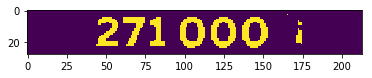

In [22]:
plt.imshow(bwimg)

In [4]:
def get_chars(img):
    """Break an image of numbers into a list of images of characters
    
    Reference: https://stackoverflow.com/questions/50713023/license-plate-character-segmentation-python-opencv
    """
    chars=[]
    _,contours,_=cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    # Sort bounding boxes from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    for ctr in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = img[y:y+h, x:x+w]
        chars.append(roi)
    return chars

def filter_chars(img):
    """Filter out non-character glyphs based on height/width ratio
    """
    h,w=img.shape
    ratio=h/w
    if ratio<=1 or ratio>2.1:
        return False
    else:
        return True
        

def conform_size(img):
    """Resize images to conform to the size of MNIST images, which is 28x28
    """
    target_width=20
    target_height=20
    padding_second=4
    h,w=img.shape
    if w>h:
        # Resize without stretching
        new_h=int(np.round(h*target_height/w))
        resized_img = cv2.resize(img, (target_width, new_h))
        # Pad image
        blank=target_height-new_h
        pad_t=int(np.floor(blank/2))
        pad_b=int(np.floor((blank+1)/2))
        padded_img=cv2.copyMakeBorder(resized_img,pad_t,pad_b,0,0,cv2.BORDER_CONSTANT,value=0)
        # Do padding again to add blanks so that the image resembles those from MNIST
        # Otherwise the trained model is destined to fail
        padded_img2=cv2.copyMakeBorder(padded_img,padding_second,padding_second,padding_second,padding_second,cv2.BORDER_CONSTANT,value=0)
    else:
        new_w=int(np.round(w*target_width/h))
        resized_img = cv2.resize(img, (new_w,target_height))
        blank=target_width-new_w
        pad_l=int(np.floor(blank/2))
        pad_r=int(np.floor((blank+1)/2))
        padded_img=cv2.copyMakeBorder(resized_img,0,0,pad_l,pad_r,cv2.BORDER_CONSTANT,value=0)
        padded_img2=cv2.copyMakeBorder(padded_img,padding_second,padding_second,padding_second,padding_second,cv2.BORDER_CONSTANT,value=0)
    # 0-255 to 0-1
    normalized=padded_img2/255
    normalized = normalized.reshape(28, 28, 1)
    return normalized

In [23]:
characters=get_chars(bwimg)
filt_chars=[img for img in characters if filter_chars(img)]
# "Normalized" characters
norm_chars=[conform_size(char) for char in filt_chars]

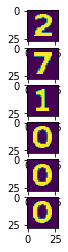

In [24]:
for i,char in enumerate(norm_chars):
    plt.subplot(len(norm_chars),1,i+1)
    plt.imshow(char[:,:,0])

In [25]:
model = tf.keras.models.load_model("models/mnist_cnn.h5")

In [26]:
model.predict_classes(np.array(norm_chars))

6/6 [==============================] - 0s


array([2, 3, 1, 0, 0, 0], dtype=int64)

In [9]:

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

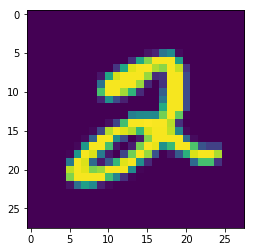

In [12]:
plt.imshow(x_train[5,:,:])